# Emotion Detector

**Importing Libraries**

In [20]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.16.1


**Exploring Dataset**

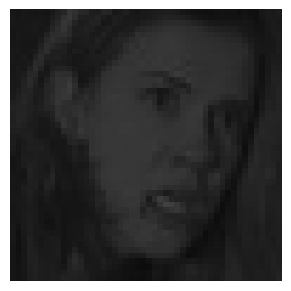

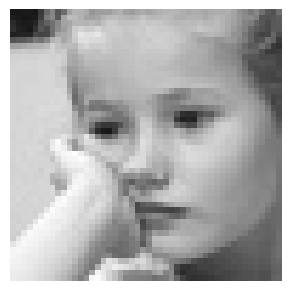

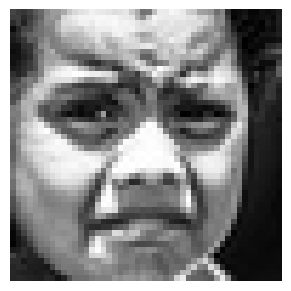

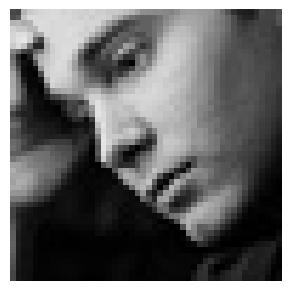

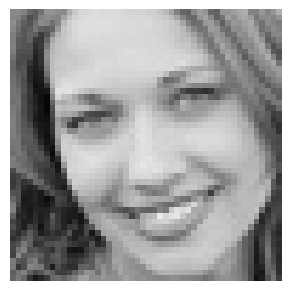

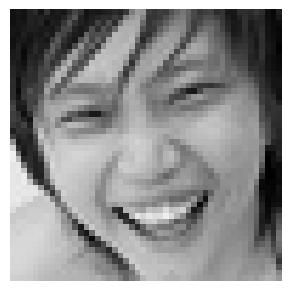

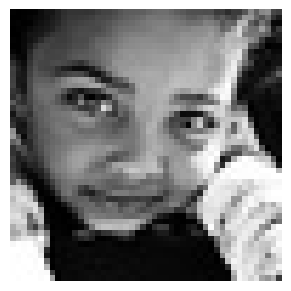

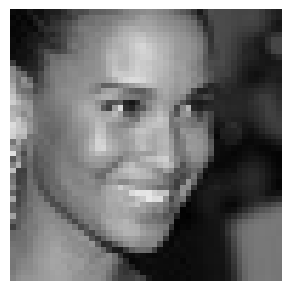

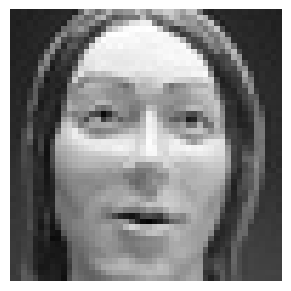

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [13]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/", target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [14]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size,padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [15]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [16]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'],optimizer = 'adam', metrics = ['accuracy'])

    return model

In [17]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the Model**

In [22]:
epochs = 15

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# Define checkpoint callback with correct file extension
checkpoint = ModelCheckpoint("model_weights.weights.h5", 
                             monitor="val_accuracy", 
                             save_weights_only=True, 
                             mode="max",
                             verbose=1)

# List of callbacks
callbacks = [checkpoint]

# Training the model

In [23]:
history = model.fit(
    x= train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


C:\Users\LENEVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3243 - loss: 1.8096
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.3245 - loss: 1.8093 - val_accuracy: 0.3152 - val_loss: 1.6788
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:08 690ms/step - accuracy: 0.5469 - loss: 1.2606
Epoch 2: saving model to model_weights.weights.h5


C:\Users\LENEVO\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5469 - loss: 1.2606 - val_accuracy: 0.3000 - val_loss: 1.5476
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.4775 - loss: 1.3737
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 316s 705ms/step - accuracy: 0.4775 - loss: 1.3736 - val_accuracy: 0.3841 - val_loss: 1.5988
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:03 680ms/step - accuracy: 0.4688 - loss: 1.3390
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4688 - loss: 1.3390 - val_accuracy: 0.4000 - val_loss: 1.3713
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5530 - loss: 1.1962
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 319s 711ms/step - accuracy: 0.5529 - loss: 1.1962 - val_accuracy: 0.3305 - val_loss: 1.8602
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:08 691ms/step - accuracy: 0.4219 - loss: 1.4986
Epoch 6: saving mo

**Model Evaluation**

In [25]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.4953 - loss: 1.5040


[1.5268046855926514, 0.48774030804634094]

**Plotting Loss**

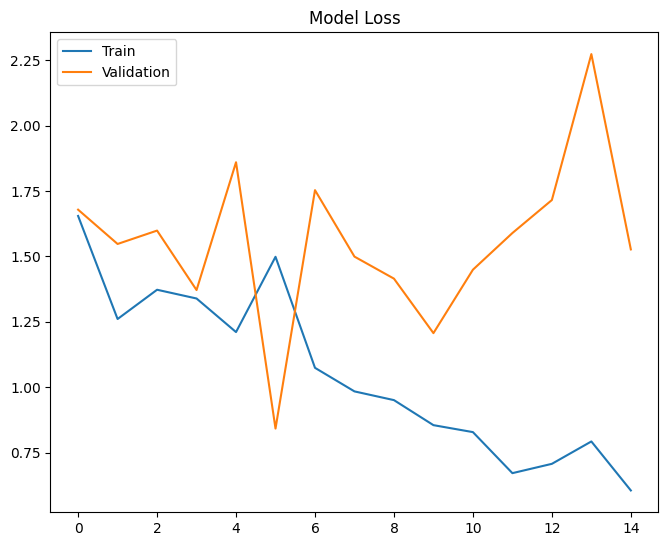

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = "upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

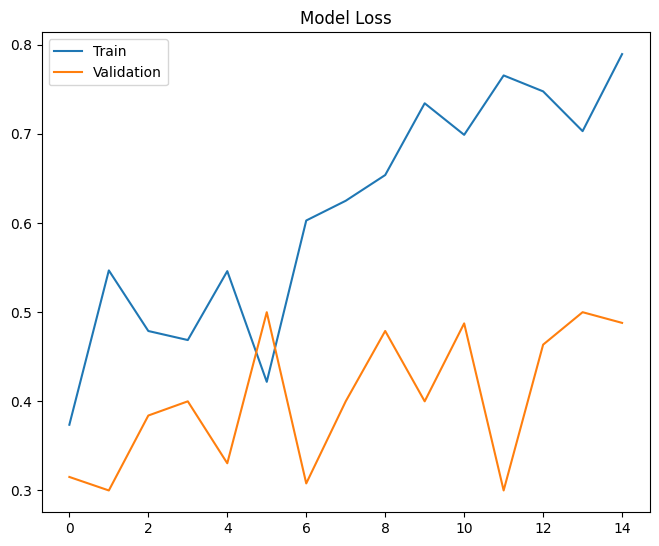

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = "upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**


In [30]:
model_json = model.to_json()
with open('model_a.json','w') as json_file:
    json_file.write(model_json)